### Crop Pest and Disease

## Import Library & Dataset

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from PIL import Image, UnidentifiedImageError, ImageEnhance, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = False
from pathlib import Path
from collections import Counter, defaultdict
import hashlib
import shutil
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

## Model:MobileNetV2

In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 16839 files belonging to 22 classes.
Found 3598 files belonging to 22 classes.
Found 3634 files belonging to 22 classes.


In [13]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']
22


In [14]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

In [ ]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)

# Fine tuning — freeze 100 layer awal
for layer in base_model.layers[:100]:
    layer.trainable = False

# Unfreeze layer akhir
for layer in base_model.layers[100:]:
    layer.trainable = True


model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(22, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 18s 2us/step



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 22)             │        28,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,286,166 (8.72 MB)

 Trainable params: 1,889,622 (7.21 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [17]:
train_labels_list = []

for _, labels in train_ds.unbatch():
    train_labels_list.append(int(labels.numpy()))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=train_labels_list
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.6325694966190833), 1: np.float64(2.7934638354346384), 2: np.float64(0.7998005129666572), 3: np.float64(0.7939928328932478), 4: np.float64(0.6508580705009277), 5: np.float64(0.42194547459156057), 6: np.float64(0.746740576496674), 7: np.float64(1.079561482241313), 8: np.float64(0.9166575939031029), 9: np.float64(0.9838163122224819), 10: np.float64(3.865702479338843), 11: np.float64(1.62507237984945), 12: np.float64(5.390204865556978), 13: np.float64(1.1721425588194347), 14: np.float64(1.394187779433681), 15: np.float64(1.0660293745251963), 16: np.float64(1.194085945255992), 17: np.float64(2.3623737373737375), 18: np.float64(0.8514005460612802), 19: np.float64(2.1440030557677616), 20: np.float64(0.47689039932030586), 21: np.float64(1.4174242424242425)}


In [19]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 340s 614ms/step - accuracy: 0.2757 - loss: 2.2064 - val_accuracy: 0.0956 - val_loss: 16.7474
Epoch 2/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 328s 610ms/step - accuracy: 0.3652 - loss: 1.7986 - val_accuracy: 0.0523 - val_loss: 12.9823
Epoch 3/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 232s 431ms/step - accuracy: 0.4112 - loss: 1.6134 - val_accuracy: 0.0570 - val_loss: 17.4535
Epoch 4/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 242s 450ms/step - accuracy: 0.4463 - loss: 1.5039 - val_accuracy: 0.0686 - val_loss: 7.4573
Epoch 5/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 232s 432ms/step - accuracy: 0.4683 - loss: 1.4139 - val_accuracy: 0.0586 - val_loss: 11.7316
Epoch 6/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 230s 428ms/step - accuracy: 0.4968 - loss: 1.3176 - val_accuracy: 0.0392 - val_loss: 17.6583
Epoch 7/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 228s 425ms/step - accuracy: 0.5162 - loss: 1.2547 - val_accuracy: 0.0384 - val_loss: 15.1197
Epoch 8/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 232s 431ms/step - accuracy: 0.

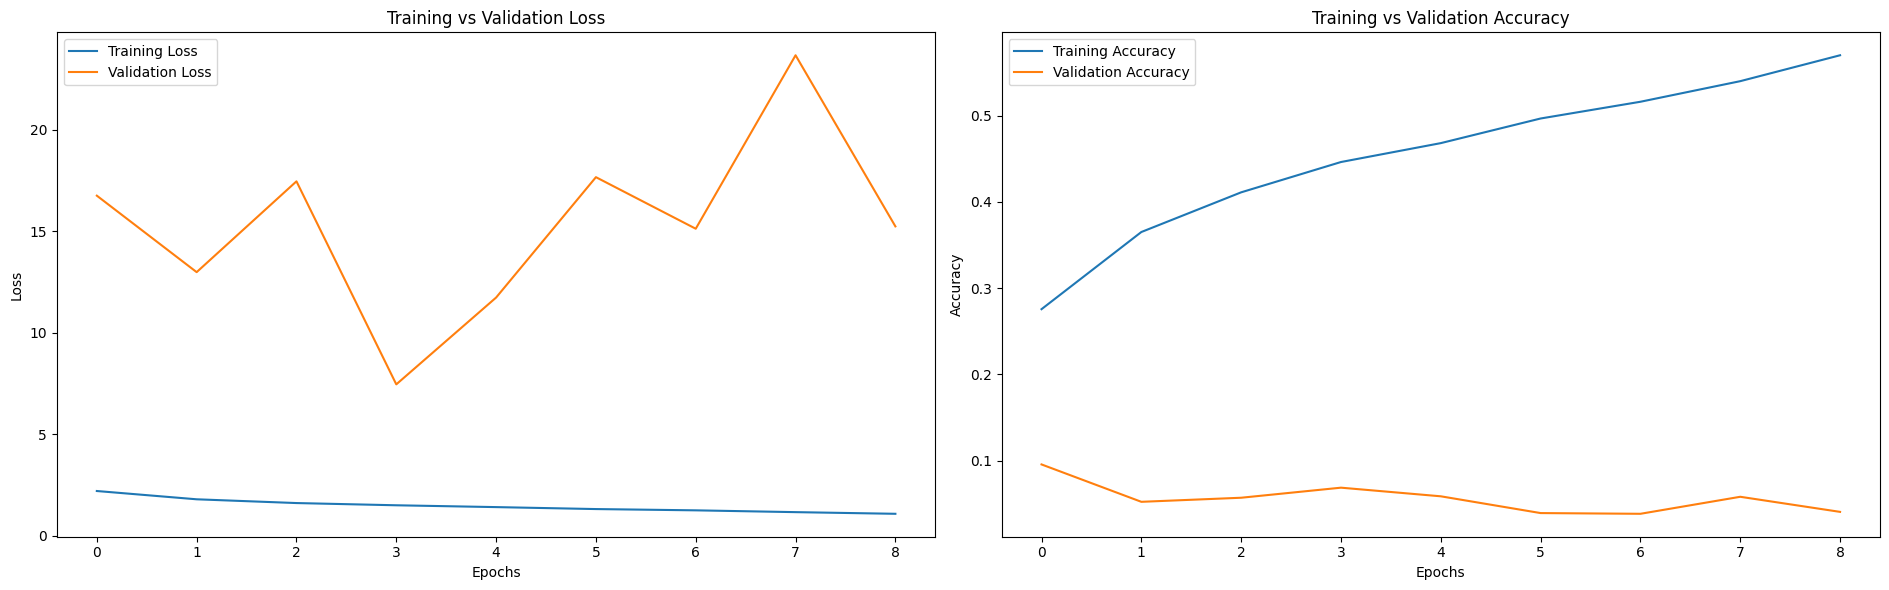

In [21]:
plt.figure(figsize=(19, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

114/114 ━━━━━━━━━━━━━━━━━━━━ 35s 307ms/step - accuracy: 0.0680 - loss: 7.5055
Test Accuracy: 0.0679691806435585
Test Loss: 7.505509376525879


In [23]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [24]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                           precision    recall  f1-score   support

       Cashew anthracnose       0.00      0.00      0.00       260
           Cashew gumosis       0.29      0.43      0.34        60
           Cashew healthy       0.06      0.75      0.10       206
        Cashew leaf miner       0.00      0.00      0.00       208
          Cashew red rust       0.00      0.00      0.00       253
 Cassava bacterial blight       0.00      0.00      0.00       390
       Cassava brown spot       0.00      0.00      0.00       221
       Cassava green mite       1.00      0.01      0.01       153
          Cassava healthy       0.00      0.00      0.00       180
           Cassava mosaic       0.00      0.00      0.00       168
      Maize fall armyworm       0.00      0.00      0.00        44
         Maize grasshoper       0.03      0.23      0.06       102
            Maize healthy       0.00      0.00      0.00        31
        Maize leaf beetle       0.00  

c:\Users\jason\OneDrive\Attachments\environments\computer_vision\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jason\OneDrive\Attachments\environments\computer_vision\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jason\OneDrive\Attachments\environments\computer_vision\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

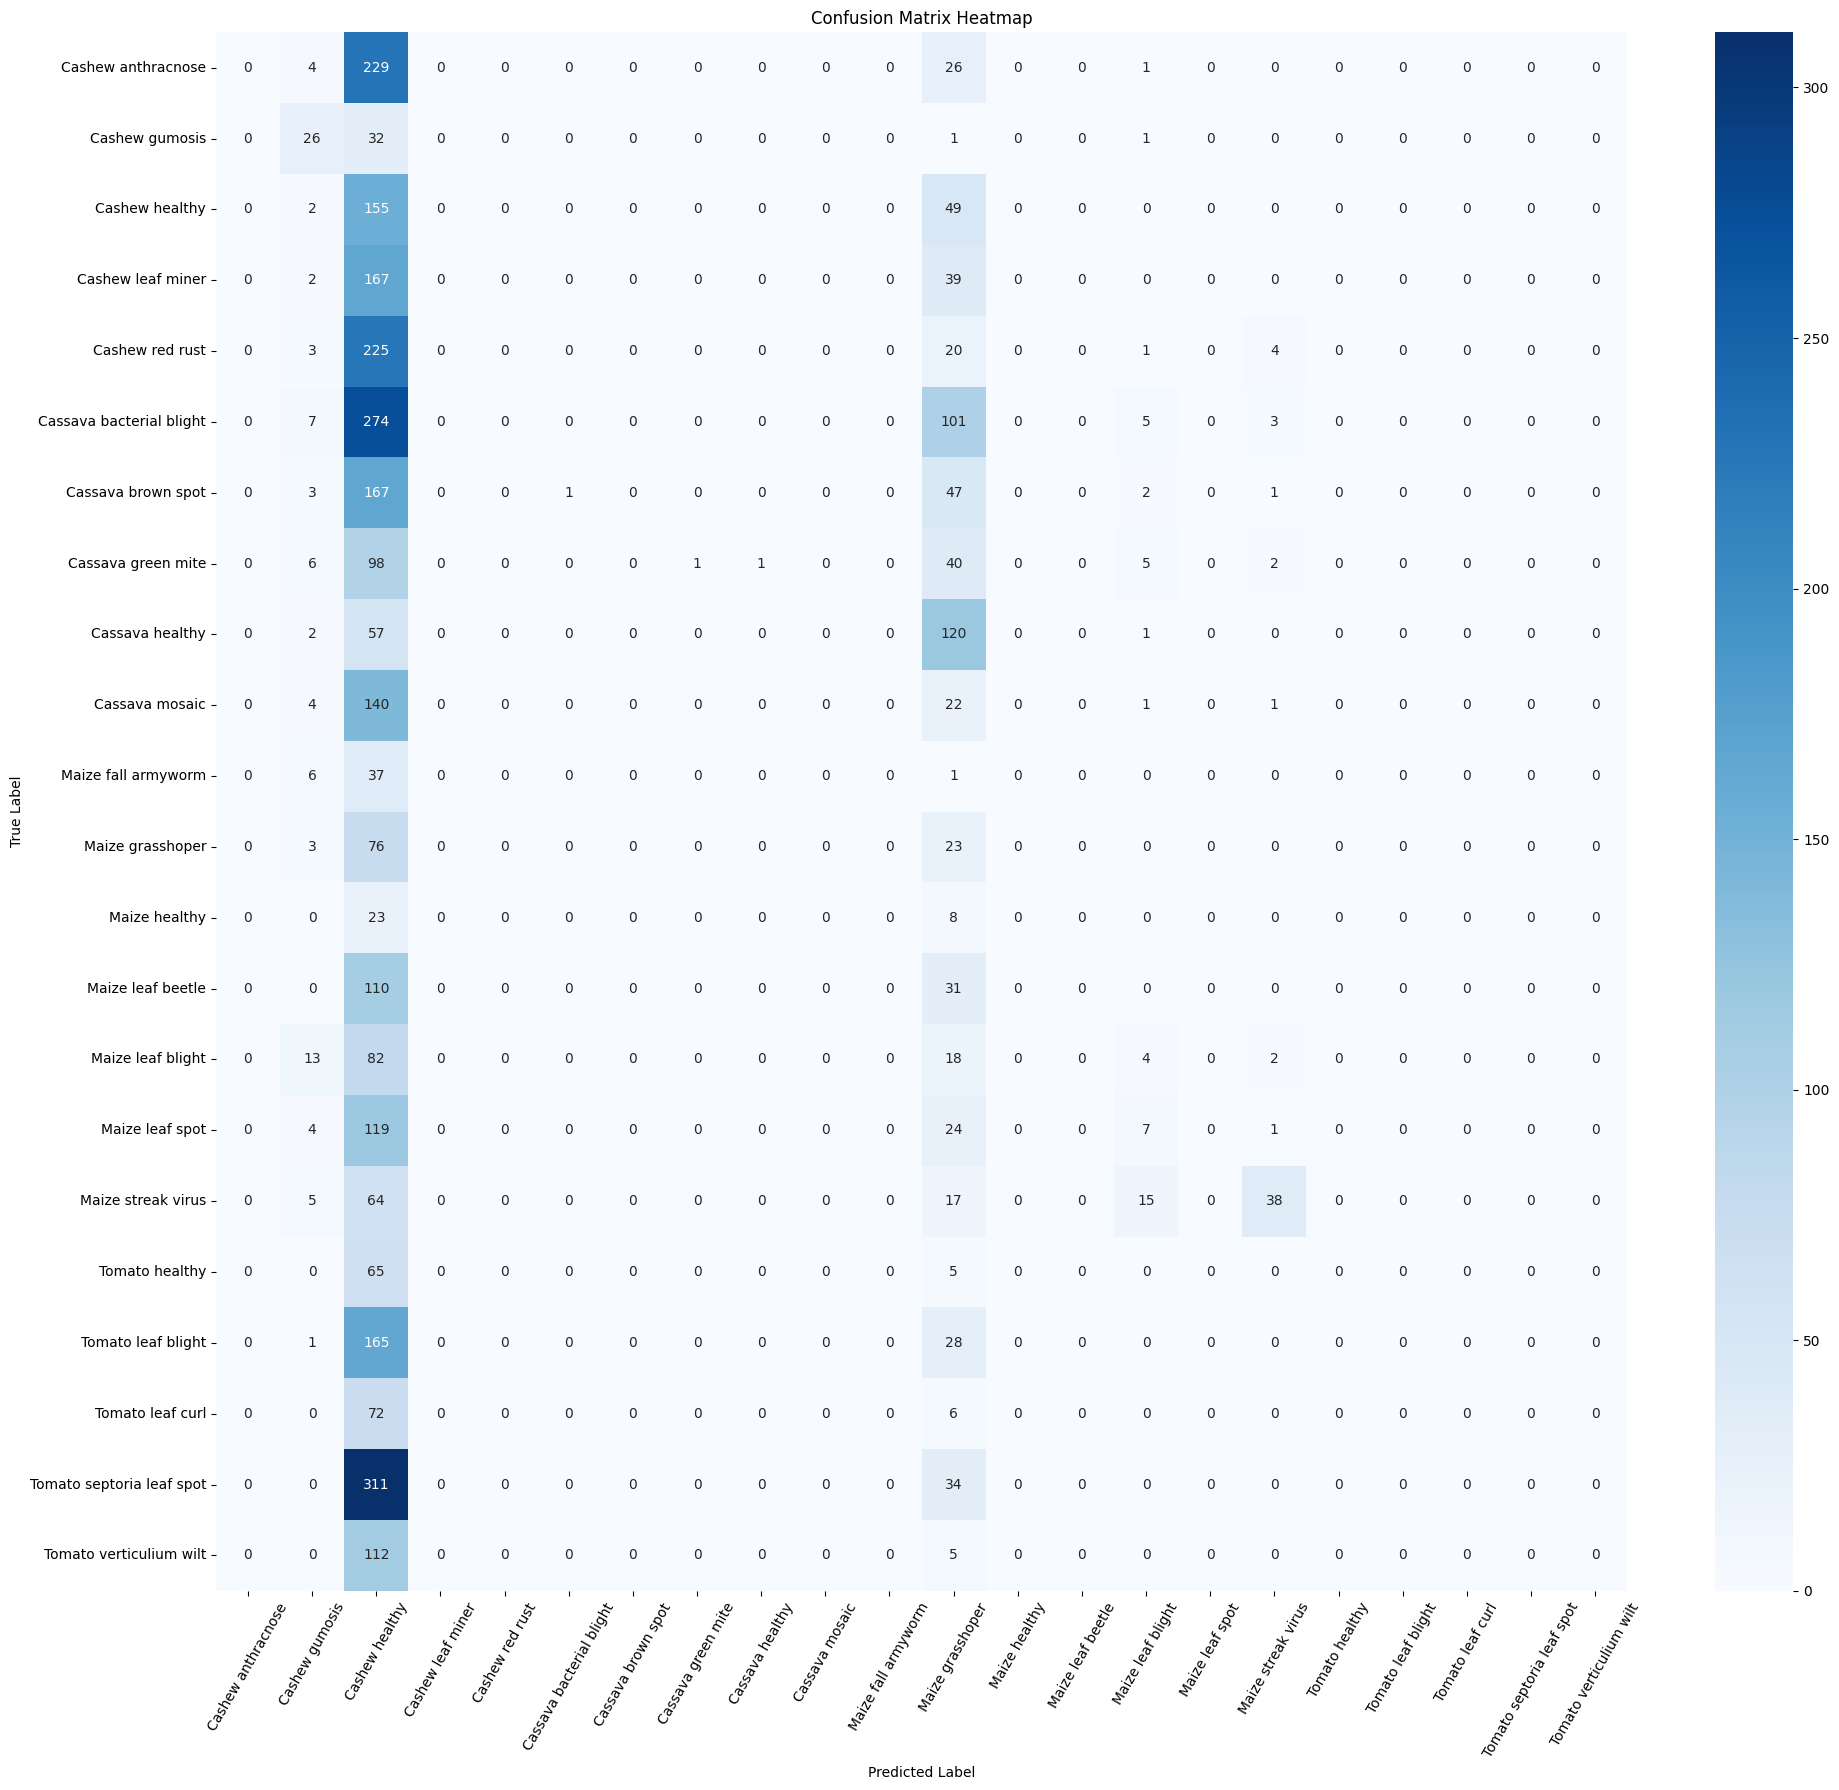

In [25]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 18))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()